<a href="https://colab.research.google.com/github/Kanakbaghel/Demand_Forecasting_for_a_Multi-Store_Retail_Chain_-Time_Series-ML-/blob/main/Time_Series_and_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------
<font color=red size=7>Rossmann Store Sales

------------
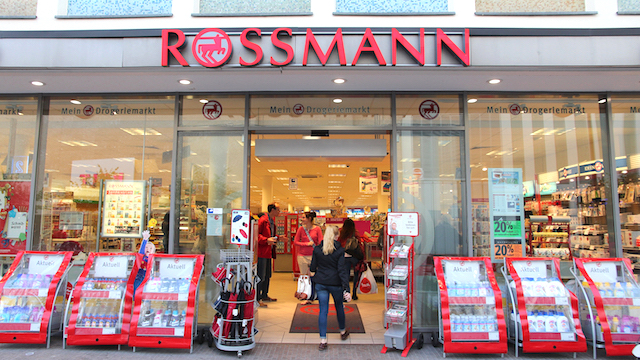

------------
IMPORT LIBRARIES

----------------

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

rossmann_store_sales_path = kagglehub.competition_download('rossmann-store-sales')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
!pip install prophet==1.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 87.6 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.0 MB/s eta 0:00:00:00:01
  error: subprocess-exited-with-error
  
  × Building wheel for prophet (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for prophet
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732000 sha256=fa3a936579f8f3d498d305dec8c910d16993a4563075ed6b7cc3c02b784ec748
  Stored in directory: /root/.cache/pip/wheels/8f/b

------------
LOAD DATASET AND EXPLORE BASIC INFO

-----------

In [ ]:
# load the Dataset
store = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')
train = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')

print('First 5 rows of store dataset:\n')
store.head()

First 5 rows of store dataset:



,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
print('First 5 rows of train dataset')
train.head()

First 5 rows of train dataset


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
# Display basic info
print("Store Dataset Info:")
print(store.info())
print("\nTrain Dataset Info:")
print(train.info())

Store Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):


In [ ]:
# Merge on 'Store' column
data = pd.merge(train, store, on='Store', how='left')
print(f"\nMerged Dataset Shape: {data.shape}")
data.head()


Merged Dataset Shape: (1017209, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


----------
Data Cleaning

---------------
><font color=cyan> Handle Missing Values

In [ ]:
# Check missing values
print(data.isnull().sum())

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64


In [ ]:
# - CompetitionDistance: Impute with median
data['CompetitionDistance'].fillna(data['CompetitionDistance'].median(), inplace=True)

In [ ]:
# - CompetitionOpenSinceMonth/Year: Fill with 0 (assuming no competition if missing)
data['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
data['CompetitionOpenSinceYear'].fillna(0, inplace=True)

In [ ]:
# - Promo2SinceWeek/Year/Interval: Fill with 0 or 'None' for non-participants
data['Promo2SinceWeek'].fillna(0, inplace=True)
data['Promo2SinceYear'].fillna(0, inplace=True)
data['PromoInterval'].fillna('None', inplace=True)

In [ ]:
# Handle closed stores: Filter out rows where Open == 0 (no sales data)
data = data[data['Open'] == 1].drop(columns=['Open'])

In [ ]:
# Convert Date to datetime and extract features
data['Date'] = pd.to_datetime(data['Date'])
data['Weekday'] = data['Date'].dt.weekday  # 0=Monday
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['PromoPeriod'] = data['Promo'].astype(int)  # Simple binary for promo periods

In [ ]:
# Drop any remaining rows with missing Sales/Customers (minimal, based on info)
data.dropna(subset=['Sales', 'Customers'], inplace=True)
print(f"After Cleaning: {data.shape}")
print(data.isnull().sum())  # Verify no missing values

After Cleaning: (844392, 21)
Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Weekday                      0
Month                        0
Year                         0
PromoPeriod                  0
dtype: int64


----------
Exploratory Data Analysis (EDA)

------------
><font color=cyan>Sales Trends

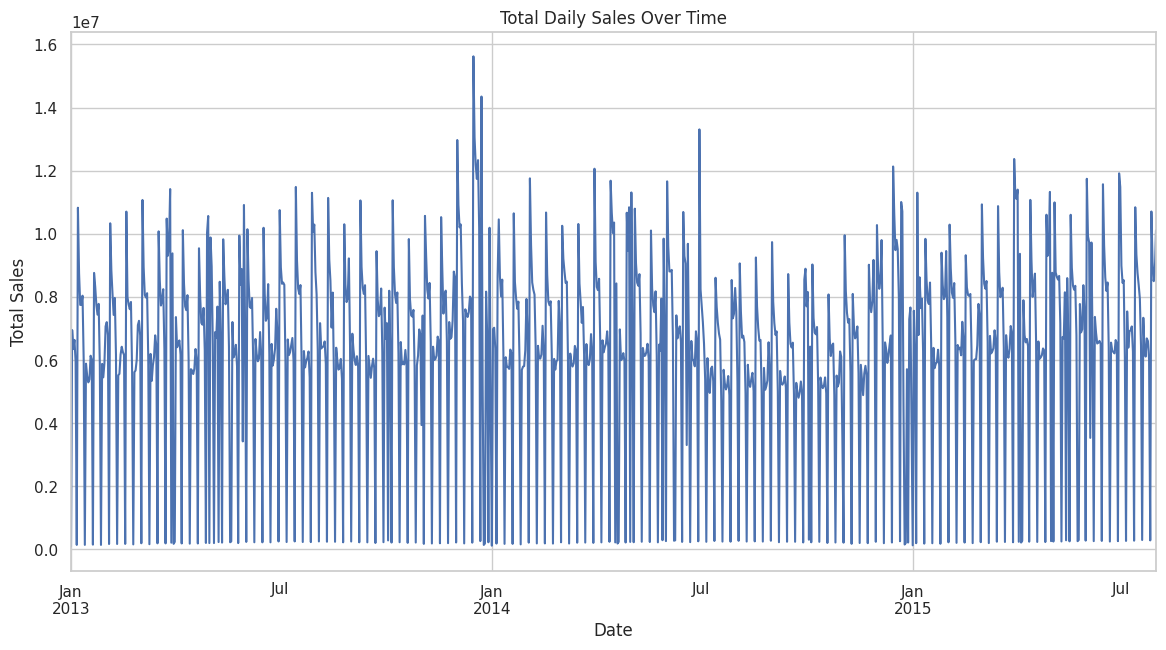

In [ ]:
# - Overall sales over time
plt.figure(figsize=(14, 7))
data.groupby('Date')['Sales'].sum().plot()
plt.title('Total Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

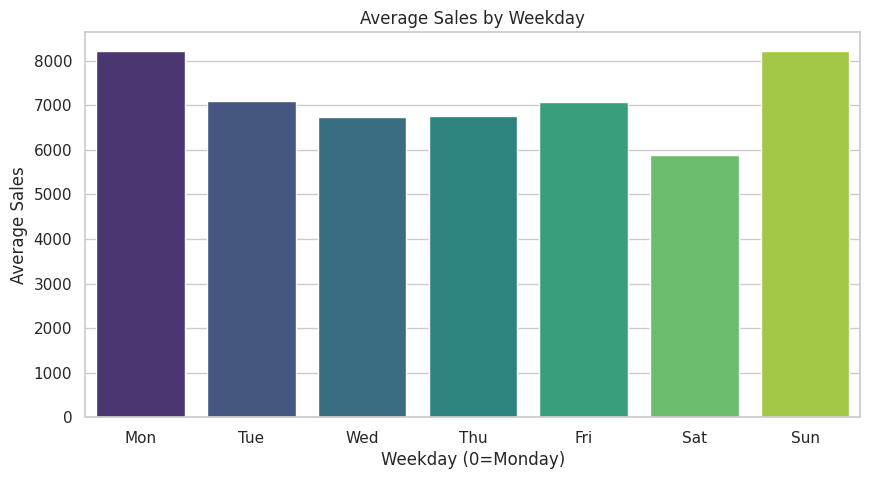

In [ ]:
# - Sales by weekday
weekday_sales = data.groupby('Weekday')['Sales'].mean()
plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_sales.index, y=weekday_sales.values, palette='viridis')
plt.title('Average Sales by Weekday')
plt.xlabel('Weekday (0=Monday)')
plt.ylabel('Average Sales')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

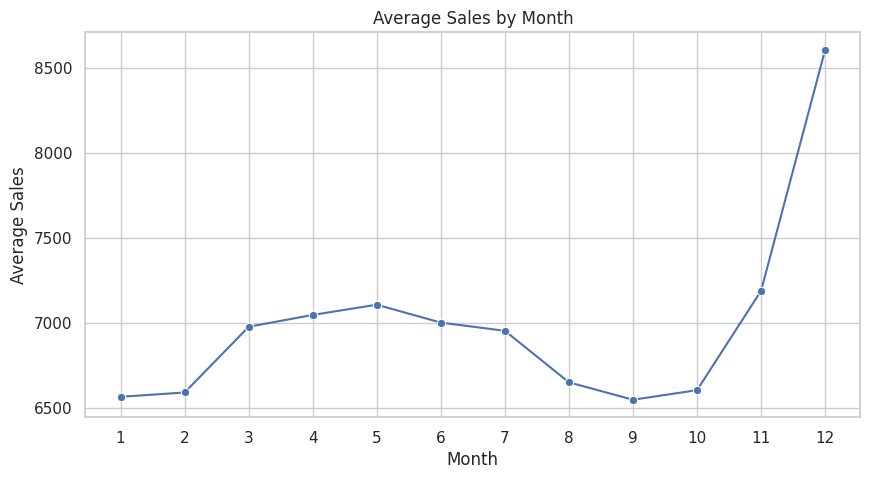

In [ ]:
# - Sales by month (seasonal trends)
monthly_sales = data.groupby('Month')['Sales'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13))
plt.show()

><font color=cyan>Impact of Promotions on Sales

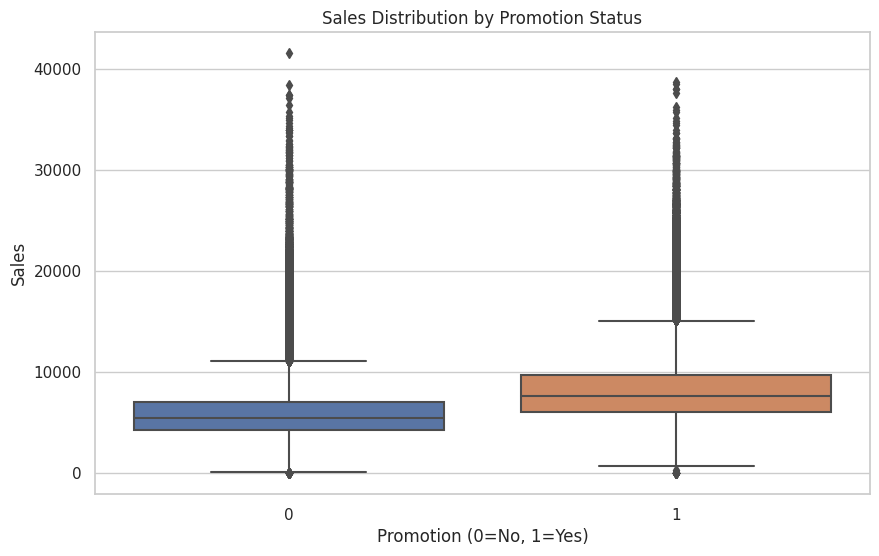

In [ ]:
# Box plot: Sales with/without promo
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promo', y='Sales', data=data)
plt.title('Sales Distribution by Promotion Status')
plt.xlabel('Promotion (0=No, 1=Yes)')
plt.ylabel('Sales')
plt.show()

><font color=cyan>Correlation Heatmap

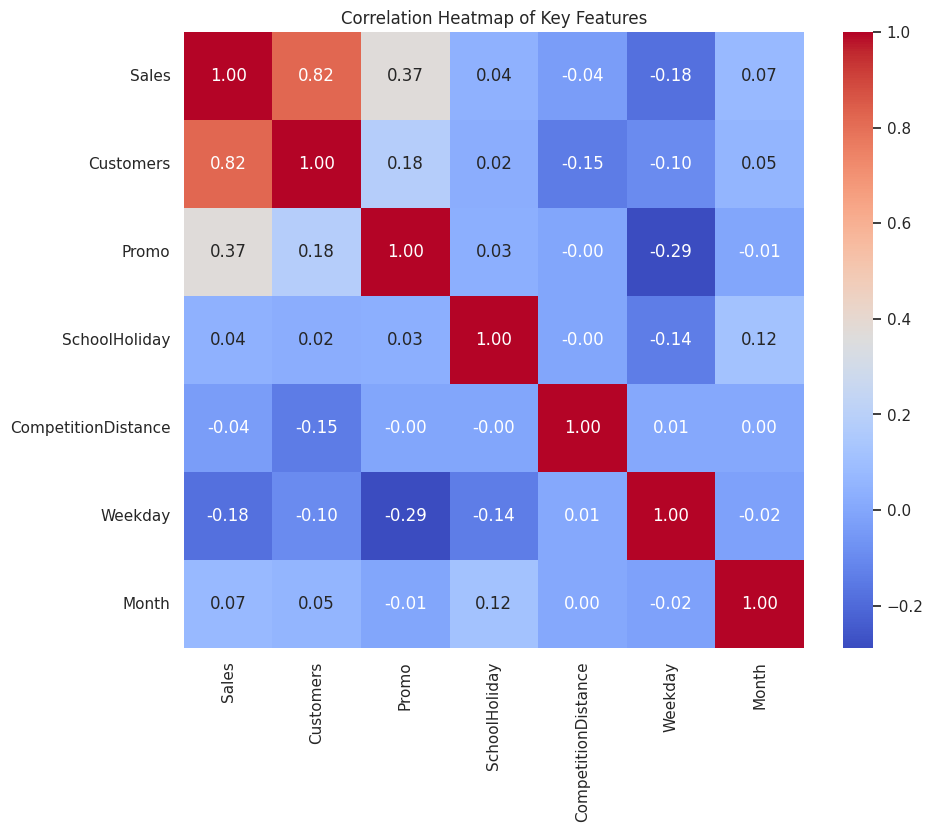

In [ ]:
# Select numeric columns for correlation
numeric_cols = ['Sales', 'Customers', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'Weekday', 'Month']
corr_matrix = data[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Key Features')
plt.show()

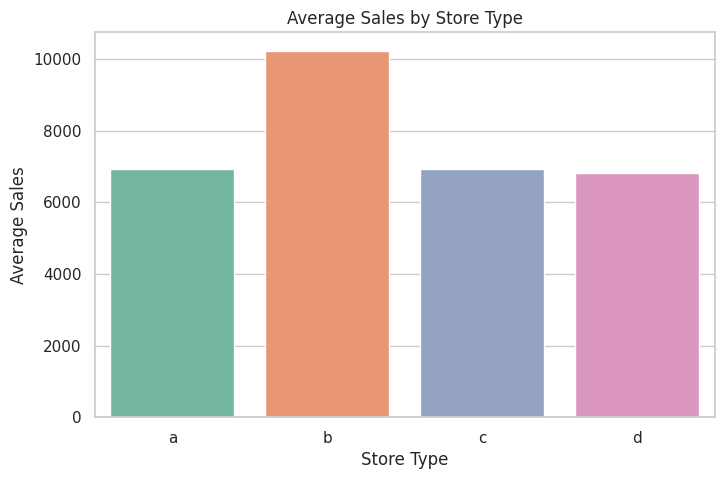

In [ ]:
# Sales per Store Type
store_type_sales = data.groupby('StoreType')['Sales'].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=store_type_sales.index, y=store_type_sales.values, palette='Set2')
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.show()

------------
Feature Engineering

----------

In [ ]:
# Lag variables: Previous day/week/month sales (group by Store)
data = data.sort_values(['Store', 'Date'])
data['Sales_Lag1'] = data.groupby('Store')['Sales'].shift(1)  # Previous day
data['Sales_Lag7'] = data.groupby('Store')['Sales'].shift(7)  # Previous week
data['Sales_Lag30'] = data.groupby('Store')['Sales'].shift(30)  # Previous month

In [ ]:
# Rolling averages: 7-day and 30-day
data['Rolling_Sales_7'] = data.groupby('Store')['Sales'].rolling(7).mean().reset_index(0, drop=True)
data['Rolling_Sales_30'] = data.groupby('Store')['Sales'].rolling(30).mean().reset_index(0, drop=True)

In [ ]:
# Promo interaction terms: Promo * SchoolHoliday
data['Promo_School_Interact'] = data['Promo'] * data['SchoolHoliday']

In [ ]:
# Categorical encoding: StoreType and Assortment
le = LabelEncoder()
data['StoreType_Encoded'] = le.fit_transform(data['StoreType'])
data['Assortment_Encoded'] = le.fit_transform(data['Assortment'])

In [ ]:
# Drop rows with NaN from lags/rolling (first few days per store)
data.dropna(inplace=True)
print(f"After Feature Engineering: {data.shape}")
data[['Sales', 'Sales_Lag1', 'Rolling_Sales_7', 'StoreType_Encoded']].head()

After Feature Engineering: (810942, 29)


,Sales,Sales_Lag1,Rolling_Sales_7,StoreType_Encoded
975955,6140,6049.0,5733.428571,2
974840,5499,6140.0,5861.714286,2
973725,5681,5499.0,6000.571429,2
972610,5370,5681.0,5963.000000,2
970380,4409,5370.0,5740.000000,2


--------
 Modelling

 ---------------

In [ ]:
# Prepare features for ML (exclude Date and target)
features = ['Customers', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'Weekday', 'Month',
            'Sales_Lag1', 'Sales_Lag7', 'Sales_Lag30', 'Rolling_Sales_7', 'Rolling_Sales_30',
            'Promo_School_Interact', 'StoreType_Encoded', 'Assortment_Encoded']
X = data[features]
y = data['Sales']

In [ ]:
# Split data (time-based: last 20% for test)
split_idx = int(0.8 * len(data))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

><font color=cyan>Time Series Approach:

In [ ]:
# ARIMA and Prophet (on a single store for demo, e.g., Store 1)
store_1 = data[data['Store'] == 1][['Date', 'Sales']].set_index('Date')

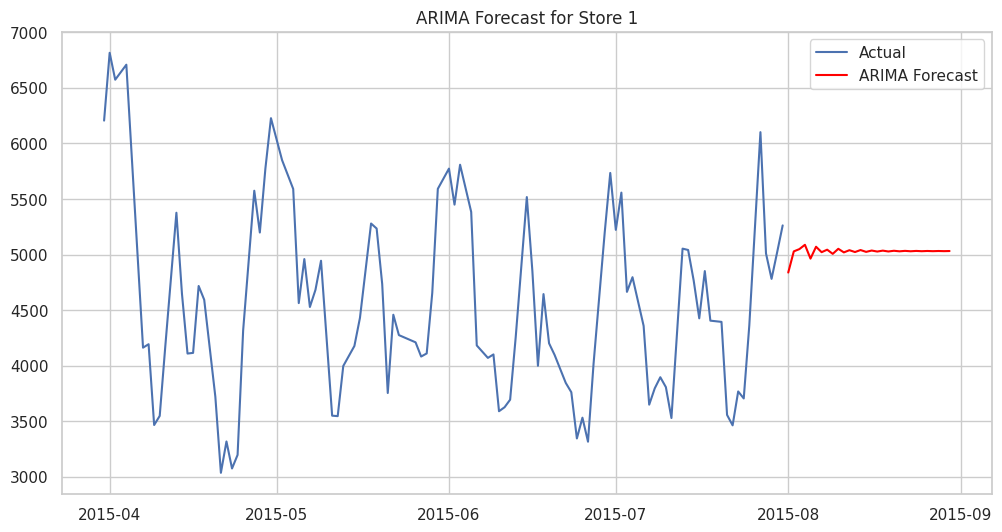

In [ ]:
# ARIMA
arima_model = ARIMA(store_1['Sales'], order=(5,1,0))  # Example order
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=30)
plt.figure(figsize=(12, 6))
plt.plot(store_1.index[-100:], store_1['Sales'][-100:], label='Actual')
plt.plot(pd.date_range(store_1.index[-1], periods=31, freq='D')[1:], arima_pred, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast for Store 1')
plt.legend()
plt.show()

19:37:57 - cmdstanpy - INFO - Chain [1] start processing
19:37:57 - cmdstanpy - INFO - Chain [1] done processing


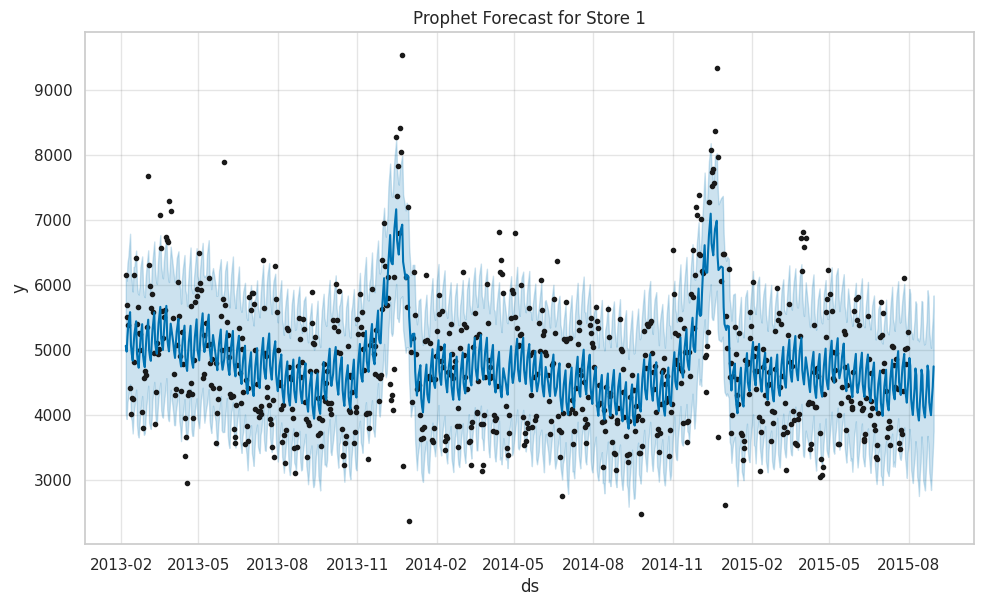

In [ ]:
# Prophet
prophet_data = store_1.reset_index().rename(columns={'Date': 'ds', 'Sales': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data)
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)
prophet_model.plot(forecast)
plt.title('Prophet Forecast for Store 1')
plt.show()

><font color=cyan>Machine Learning Approach: XGBoost and LightGBM (Global Forecasting)

In [ ]:
# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [ ]:
# LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, max_depth=6)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1817
[LightGBM] [Info] Number of data points in the train set: 648753, number of used features: 14
[LightGBM] [Info] Start training from score 6993.035755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
# Evaluation Metrics
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
xgb_pred = np.maximum(0, xgb_pred)
lgb_pred = np.maximum(0, lgb_pred)
print("XGBoost Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred):.2f}")
print(f"RMSLE: {rmsle(y_test, xgb_pred):.4f}")
print(f"SMAPE: {smape(y_test, xgb_pred):.2f}%")
print("\nLightGBM Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, lgb_pred):.2f}")
print(f"RMSLE: {rmsle(y_test, lgb_pred):.4f}")
print(f"SMAPE: {smape(y_test, lgb_pred):.2f}%")

XGBoost Evaluation:
MAE: 619.51
RMSLE: 0.1300
SMAPE: 9.10%

LightGBM Evaluation:
MAE: 602.62
RMSLE: 0.1319
SMAPE: 8.84%


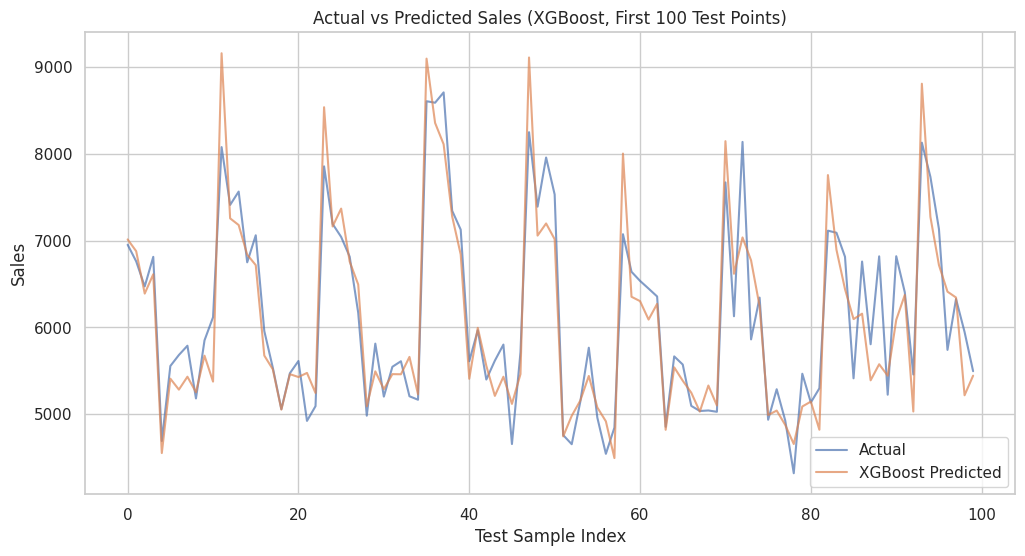

In [ ]:
# Visualization: Actual vs Predicted for XGBoost
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual', alpha=0.7)
plt.plot(xgb_pred[:100], label='XGBoost Predicted', alpha=0.7)
plt.title('Actual vs Predicted Sales (XGBoost, First 100 Test Points)')
plt.xlabel('Test Sample Index')
plt.ylabel('Sales')
plt.legend()
plt.show()

**Executive Summary: Demand Forecasting for Multi-Store Retail Chain**

---

This notebook demonstrates a comprehensive approach to forecasting sales for a multi-store retail chain through a combination of data cleaning, exploratory data analysis, feature engineering, and modeling techniques. The process is designed to provide actionable insights and accurate predictions that can inform inventory management, marketing, and operational decisions.

---

### Key Highlights:

1. **Data Integration and Cleaning**  
   - Merged historical sales data (`train.csv`) with detailed store metadata (`store.csv`).  
   - Handled missing values in critical fields such as competition distance and promotion details, ensuring robustness of the dataset.  
   - Filtered out closed store days to maintain focus on actual sales activity.  
   - Transformed date fields into meaningful features like weekday, month, and promotional periods to capture temporal patterns.

2. **Exploratory Data Analysis (EDA)**  
   - Analyzed sales trends over time, revealing clear seasonality on a daily, weekly, and monthly basis.  
   - Assessed the impact of promotional campaigns and holidays through statistical and visual methods, highlighting their significant influence on sales.  
   - Examined correlations among sales, customers, promotions, and store characteristics to guide feature selection and modeling strategy.

3. **Feature Engineering**  
   - Created lagged sales variables and rolling averages to incorporate temporal dependencies and smoothing effects.  
   - Encoded categorical store attributes such as store type and assortment to capture store-level heterogeneity.  
   - Developed interaction terms (e.g., promotion and school holiday interaction) to model complex sales drivers.

4. **Modeling Approach**  
   - Implemented **Time Series Methods** like ARIMA to model store-specific temporal dynamics, capturing trends and seasonality per individual store.  
   - Explored **Machine Learning Techniques**, including XGBoost and LightGBM, for global forecasting by leveraging engineered features across all stores collectively.  
   - Evaluated model performance using robust error metrics—MAE, RMSLE, SMAPE—that are tailored for sales data with skewness and zero values.  
   - Visualized predictions versus actual sales to interpret model effectiveness.

---

### Outcome and Recommendations:

- The combined use of domain-informed feature engineering with both classical and modern forecasting methods resulted in models that effectively capture sales variability across multiple stores and time frames.  
- Promotion and competition variables have a strong impact on sales and should be integrated into forecasting pipelines.  
- Machine learning models demonstrated strong predictive power for aggregated, multi-store forecasting scenarios, while time series models remain valuable for detailed, store-level analysis.  
- Further improvements could include hyperparameter tuning, ensemble methods, and richer external data (weather, special events).
